# <span style="background-color: darkgreen;">SAE : Mener une étude statistique dans un domaine d'application </span>



## <u>Projet</u>: Clustering probabiliste (London Bike Sharing Dataset)

### 1) Extraction et exploration des données

In [1]:
import pandas as pd

# Chargement des datasets
journeys = pd.read_csv('journeys.csv')
stations = pd.read_csv('stations.csv')

# Inspection de stations.csv
print("\nForme de stations :", stations.shape)
print("Nombre unique d'ID de stations :", stations['Station ID'].nunique())
print("Colonnes de stations :", stations.columns.tolist())
print("Aperçu des 5 premières lignes :\n", stations.head())


Forme de stations : (773, 5)
Nombre unique d'ID de stations : 773
Colonnes de stations : ['Station ID', 'Capacity', 'Latitude', 'Longitude', 'Station Name']
Aperçu des 5 premières lignes :
    Station ID  Capacity   Latitude  Longitude  \
0           1        19  51.529163  -0.109970   
1           2        37  51.499606  -0.197574   
2           3        32  51.521283  -0.084605   
3           4        23  51.530059  -0.120973   
4           5        27  51.493130  -0.156876   

                           Station Name  
0            River Street , Clerkenwell  
1        Phillimore Gardens, Kensington  
2  Christopher Street, Liverpool Street  
3       St. Chad's Street, King's Cross  
4         Sedding Street, Sloane Square  


Au total, notre jeu de données contient 773 lignes (soit 773 stations de vélos) et 5 colonnes.

In [2]:
print("Valeurs manquantes :\n", stations.isnull().sum())

Valeurs manquantes :
 Station ID      0
Capacity        0
Latitude        0
Longitude       0
Station Name    0
dtype: int64


Aucune valeur manquante dans le dataset !!

In [3]:
# Inspection de journeys.csv
print("Forme de journeys :", journeys.shape)  # Nombre de lignes et colonnes
print("Colonnes de journeys :", journeys.columns.tolist())

Forme de journeys : (1542844, 14)
Colonnes de journeys : ['Journey Duration', 'Journey ID', 'End Date', 'End Month', 'End Year', 'End Hour', 'End Minute', 'End Station ID', 'Start Date', 'Start Month', 'Start Year', 'Start Hour', 'Start Minute', 'Start Station ID']


Le dataset journeys a 1 542 844 lignes et 14 colonnes, soit 1 542 844 trajets d'une station à une autre. À priori, les colonnes d'intérêt pour nos premières analyses à savoir la constitution de la matrice carrée A d'adjacence (où A[i,j] représentera le nombre de trajets de la station i à joù A[i,j] représentera le nombre de trajets de la station i à j) sont 'Journey ID' (l'identifiant d'un trajet entre deux stations), 'Start Staion ID' et 'End Station ID' (respectivement les stations de départ et d'arrivée du trajet).

In [4]:
print("Aperçu des 5 premières lignes :\n", journeys.head())

Aperçu des 5 premières lignes :
    Journey Duration  Journey ID  End Date  End Month  End Year  End Hour  \
0            2040.0         953        19          9        17        18   
1            1800.0       12581        19          9        17        15   
2            1140.0        1159        15          9        17        17   
3             420.0        2375        14          9        17        12   
4            1200.0       14659        13          9        17        19   

   End Minute  End Station ID  Start Date  Start Month  Start Year  \
0           0             478          19            9          17   
1          21             122          19            9          17   
2           1             639          15            9          17   
3          16             755          14            9          17   
4          33             605          13            9          17   

   Start Hour  Start Minute  Start Station ID  
0          17            26              

In [5]:
cols_to_keep = ['Journey Duration']
print("Statistiques descriptives :\n", journeys[cols_to_keep].describe())

Statistiques descriptives :
        Journey Duration
count      1.542844e+06
mean       1.328576e+03
std        6.718370e+03
min        0.000000e+00
25%        5.100000e+02
50%        8.470000e+02
75%        1.346000e+03
max        1.984700e+06


En moyenne, les trajets entre stations dure 22 minutes, ce qui semble raisonnable pour des trajets urbains en vélo. Cela dit, la forte variabilité entre les durées(écart-type de 112 minutes) met l'accent sur l'existence de quelques trajets particuliers à durées très faibles ou trop élevées (outliers potentiels). Ce que nous confirme les extrêmes de la distribution des durées (min 0 min, max 33 078 min). Une attention particulière sur ces trajets est requise.

Analysons-les étape par étape pour décider si les retirer avant de construire la matrice A indispensable pour nos analyses.


In [6]:
Min = journeys['Journey Duration'].min()
Max = journeys['Journey Duration'].max()

lines = (journeys['Journey Duration'] == Min) | (journeys['Journey Duration'] == Max)
journeys.loc[lines].sort_values(by='Journey Duration', ascending=False)

,Journey Duration,Journey ID,End Date,End Month,End Year,End Hour,End Minute,End Station ID,Start Date,Start Month,Start Year,Start Hour,Start Minute,Start Station ID
1346083,1984700.0,2540,24,8,17,17,25,123,1,8,17,18,6,93
1109644,0.0,5285,8,8,17,8,47,215,8,8,17,8,47,215
1097635,0.0,7744,22,8,17,19,5,676,22,8,17,19,5,676
5827,0.0,8281,16,9,17,14,22,626,16,9,17,14,22,626
1541077,0.0,12366,7,8,17,20,39,763,7,8,17,20,39,763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947991,0.0,13904,17,8,17,17,22,228,17,8,17,17,22,228
960153,0.0,7620,18,8,17,0,25,193,18,8,17,0,25,193
993122,0.0,8304,19,8,17,11,3,39,19,8,17,11,3,39
1047602,0.0,1792,21,8,17,9,15,717,21,8,17,9,15,717


Après inspection, le trajet de 1 984 700 secondes soit environ 33 078 minutes semble bien logique puisqu'il a débuté de la station 93 et pris fin à la station 123 et a duré du 01/08/2017 à 18h 06 au 24/08/2017 à 17h 25, soit environ 23 jours. Une idée de la distance entre ces deux stations pourraient davantage conforter notre analyse.

In [7]:
s93 = stations.set_index('Station ID').loc[93]
s123 = stations.set_index('Station ID').loc[123]

print(f"Station de départ : {s93['Station Name']}")
print(f"Station d'arrivée : {s123['Station Name']}")

# Calcul de la distance entre les stations de départ et d'arrivée pour les trajets de 1 984 700 secondes

'''
Pour calculer la distance géographique entre stations 93 et 123 en utilisant les latitudes/longitudes de stations.csv, 
nous utilisons la formule Haversine (distance à vol d'oiseau en km). Elle est basée sur la formule de la sphère terrestre.
'''

from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calcul la distance géodésique (à vol d'oiseau) entre deux points
    sur la terre (spécifiés en degrés décimaux)
    """
    # conversion des degrés décimaux en radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # formule de haversine
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 # calcul de la distance
    c = 2 * asin(sqrt(a)) # distance en radians
    r = 6371 # rayon de la terre en kilomètres
    return c * r # distance en kilomètres   

distance = haversine(s93['Longitude'], s93['Latitude'], s123['Longitude'], s123['Latitude'])
print(f"Distance entre les stations 93 et 123 : {distance:.2f} km")


Station de départ : Cloudesley Road, Angel
Station d'arrivée : St. John Street, Finsbury
Distance entre les stations 93 et 123 : 0.74 km


La distance à vol d'oiseau entre les stations 93 et 123 est de 0.74 Km. Il n'est donc pas logique qu'un trajet direct à vélo de l'une à l'autre puisse prendre 23 à jours, à moins qu'il ne s'agisse d'un prêt longue durée, d'un non-retour du vélo concerné ou d'une erreur du système. 

Cela dit, puisque nos analyses seront plus ou moins focalisées sur le flux des trajets entre stations (nombre d'occurrences, indépendamment de la durée), la durée des trajets n'est à priori pas une information capitale. Le fait qu'il y ait eu un trajet entre ces deux stations (93 et 123) est le plus important. Nous garderons donc cette ligne dans notre jeu de données pour ne pas sous-estimer les connexions rares mais existantes.

En ce qui concerne les trajets à 00s, on peut constater qu'il s'agit en réalité de trajet non effectué, puisque les informations temporelles (date, jour, heure, minute) et de localisation (station) sont exactement les mêmes. Devrons nous les retirer ? Analysons plus en détail les trajets concernés.

In [8]:
df_test = journeys.loc[journeys['Journey Duration'] == 0].copy()
df_test['test'] = (df_test['Start Station ID'] == df_test['End Station ID']) & (df_test['Start Date'] == df_test['End Date']) & (df_test['Start Hour'] == df_test['End Hour']) & (df_test['Start Minute'] == df_test['End Minute'])
print(f"Nombre de trajets potentiellement non effectués : {len(df_test)}")
print(f"Tous les trajets à 0s sont-ils des trajets non effectués ? {all(df_test['test'])}")
print(f"Nombre de trajets à 0s, mais qui ne sont pas des trajets non effectués : {(~df_test['test']).sum()}")

Nombre de trajets potentiellement non effectués : 1609
Tous les trajets à 0s sont-ils des trajets non effectués ? False
Nombre de trajets à 0s, mais qui ne sont pas des trajets non effectués : 18


Finalement, tous les trajets à 0s de notre dataset ne sont pas des non-trajets, il en existe 18 sur 1609.
Vérifions ce qui cloche avec ces trajets.

In [9]:
# Affichage des trajets à 0s qui ne sont pas des trajets non effectués
df_test[~df_test['test']]

,Journey Duration,Journey ID,End Date,End Month,End Year,End Hour,End Minute,End Station ID,Start Date,Start Month,Start Year,Start Hour,Start Minute,Start Station ID,test
131483,0.0,11039,18,9,17,19,43,701,18,9,17,19,43,632,False
138715,0.0,14438,19,9,17,9,19,217,19,9,17,9,19,200,False
175198,0.0,6512,13,9,17,7,48,361,13,9,17,7,48,154,False
228221,0.0,6104,10,9,17,16,0,372,10,9,17,16,0,809,False
252428,0.0,13130,12,9,17,18,47,272,12,9,17,18,47,347,False
255394,0.0,13408,11,9,17,8,22,251,11,9,17,8,22,507,False
329788,0.0,1493,12,9,17,8,8,735,12,9,17,8,8,659,False
336862,0.0,13145,8,9,17,9,2,374,8,9,17,9,2,154,False
362148,0.0,13003,11,9,17,8,25,379,11,9,17,8,25,661,False
430015,0.0,2803,4,9,17,8,24,361,4,9,17,8,24,154,False


On constate qu'à part les données sur les stations de départ et d'arrivée, toutes les autres informations (temporelles) sont exactement les mêmes. On en déduit qu'il s'agit certaienemt d'erreurs du système d'enregistrement des données.

Toujours est-il que la durée n'influence pas directement la matrice $A$. Elle se base uniquement sur les paires (Start Station ID, End Station ID) et dans ces cas précis nous avons des stations bien distinctes. Nous garderons donc ces lignes également.

Finalement, seuls les non-tajets seront retirés de notre jeu de données, puisqu'ils ne sont pas pertinents. Ces entrées ajouteraient des "self-loops" ($A[i,i] +=1$) artificiels, ce qui va biaiser nos analyses sur la connectivité. De plus ces entrées constituent moins de 0.5% de notre jeu de données globales.

Quid des trajets avec les mêmes stations de départ et d'arrivée, mais des informations temporelles différentes (les self-loops réels) ?

In [10]:
# Filtre self-loops avec Journey Duration > 0 
self_loops_positive = journeys[(journeys['Start Station ID'] == journeys['End Station ID']) & (journeys['Journey Duration'] > 0)]

# Nombre
count = len(self_loops_positive)
print(f"Nombre de self-loops avec Duration > 0 : {count} ({count / len(journeys) * 100:.2f}% du total)")

# Stats sur durations de ces cas
print("Stats durations :\n", self_loops_positive['Journey Duration'].describe())

Nombre de self-loops avec Duration > 0 : 72552 (4.70% du total)
Stats durations :
 count     72552.000000
mean       3043.823409
std        5639.499641
min           1.000000
25%         851.000000
50%        1710.000000
75%        3628.000000
max      460180.000000
Name: Journey Duration, dtype: float64


Nous avons 4.7% des entrées qui vérifient cette éventualité. D'ailleurs, les statistiques descriptives de ces entrées (moyenne des durées de trajet ~51 min, médiane ~28 min), indiquent des activités réelles pas négligeables, qui, à priori, devraient enrichir les patterns de mobilité globale. En les retirant, on perdrait certainement une dimension "interne" des stations et donc de l'information réelle, ce qui pourrait être pertinent pour nos analyse. Cela dit, étant donné que ces trajets ne contribuent pas à la connectivité inter-stations (liens entre $i$ et $j$ où $i \neq j$), qui est clé pour le clustering basé sur les patterns de mobilité globale, nous pouvons envisager de les retirer de notre jeu de données. De quoi obtenir une matrice A centrée sur les interactions pertinentes, sans diagonale non-zéro, l'idéal pour une modélisation probabiliste fidèle des patterns d'interactions. 

En somme, pour avoir $Z$ plus informatif (dimensions latentes capturant les transits), et un GMM sur $Z$ qui produira des clusters plus interprétables (à savoir des nœuds de transit interconnectés), on retirera ces données. En les incluant, les clusters pourraient être biaisés vers la diversité d'usage, sous-estimant les connexions externes.

In [11]:
# Retrait des self-loops non-trajets (Start Station ID == End Station ID & Journey Duration == 0)
self_loops = journeys['Start Station ID'].eq(journeys['End Station ID'])

journeys_clean = journeys.loc[~self_loops]
print(f"Nombre de trajets après nettoyage : {len(journeys_clean)} ({len(journeys_clean)/len(journeys)*100:.2f}% conservés)")


Nombre de trajets après nettoyage : 1468701 (95.19% conservés)


Tous les cas non pertinents pour nos analyses representent moins de 5% de notre jeu de données de départ. Même en les retirant, nous conservant donc la majorité de nos données pour une analyse qualitative.

In [12]:
# Inspection de journeys_clean
print("Valeurs manquantes :\n", journeys_clean.isnull().sum())
print("Nombre unique de stations de départ :", journeys_clean['Start Station ID'].nunique())
print("Nombre unique de stations d'arrivée :", journeys_clean['End Station ID'].nunique())

Valeurs manquantes :
 Journey Duration    0
Journey ID          0
End Date            0
End Month           0
End Year            0
End Hour            0
End Minute          0
End Station ID      0
Start Date          0
Start Month         0
Start Year          0
Start Hour          0
Start Minute        0
Start Station ID    0
dtype: int64
Nombre unique de stations de départ : 779
Nombre unique de stations d'arrivée : 779


Nous avons maintenant un jeu de données propre et prêt pour nos analyses. Toujours est-il que contrairement au dataset sur les stations qui contenait 773 stations uniques, celui sur les trajets en contient 779.

Pour la matrice $A$ carrée, nous devons inclure toutes les stations uniques de l'union des deux datasets pour une représentation complète. Nous éviterons ainsi de perdre des flux impliquant ces 6 stations supplémentaires. Pour les visualisations géographiques ultérieures (le clustering avec correspondance géographique via lat/long), elles auront des coordonnées manquantes. Nous les exclueront donc des plots. D'ailleurs, si ces 6 sations ont peu de trajets, leur impact sur notre matrice $Z$ issue de $A$ et le clustering sera minime.

### 2) Construction de la matrice A de connectivité

In [13]:
import numpy as np

# Stations uniques dans stations.csv
stations_ids = set(stations['Station ID'].unique())

# Stations uniques dans journeys_clean (union Start et End)
journeys_starts = set(journeys_clean['Start Station ID'].unique())
journeys_ends = set(journeys_clean['End Station ID'].unique())
journeys_ids = journeys_starts.union(journeys_ends)

# Union totale pour A carrée
all_station_ids = sorted(stations_ids.union(journeys_ids))
n_stations = len(all_station_ids)
print(f"Nombre total de stations uniques : {n_stations}") 

# Mapping ID -> index
id_to_index = {sid: idx for idx, sid in enumerate(all_station_ids)}

# Nombre de trajets
counts = journeys_clean.groupby(['Start Station ID', 'End Station ID']).size().reset_index(name='n_trips')

# Matrice A dirigée carrée
A = pd.pivot_table(counts, values='n_trips', index='Start Station ID', columns='End Station ID', fill_value=0)
A = A.reindex(index=all_station_ids, columns=all_station_ids, fill_value=0)
A_np = A.to_numpy()

np.save('A.npy', A_np)
print(f"Taille de A : {A.shape}")

Nombre total de stations uniques : 781
Taille de A : (781, 781)


Sparsité de A : 63.26%
Statistiques des counts non-zéros :
 count    224070.000000
mean          6.554653
std          13.251891
min           1.000000
25%           1.000000
50%           3.000000
75%           7.000000
max         990.000000
dtype: float64
Moyenne : 6.55, Variance : 175.61


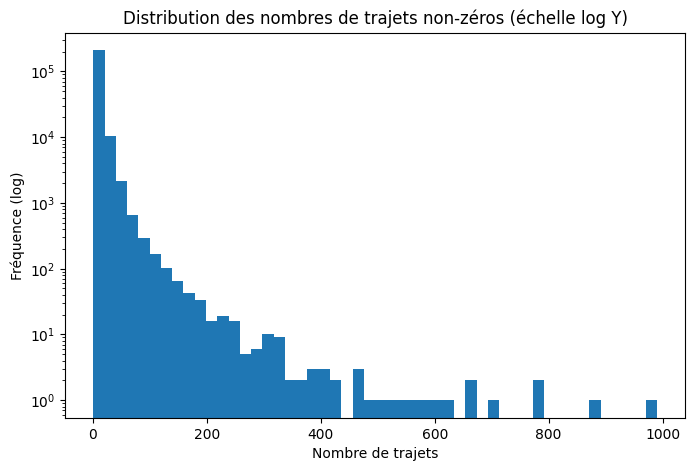

In [14]:
# Sparsité
sparsity = 1 - np.count_nonzero(A_np) / A_np.size
print(f"Sparsité de A : {sparsity:.2%}")  # % de zéros  

# Stats des counts non-zéros
non_zero = A_np[A_np > 0].flatten()
non_zero_series = pd.Series(non_zero)
print("Statistiques des counts non-zéros :\n", non_zero_series.describe())

mean = non_zero.mean()
var = non_zero.var()
print(f"Moyenne : {mean:.2f}, Variance : {var:.2f}")

# Histogramme
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.hist(non_zero, bins=50, log=True)
plt.title('Distribution des nombres de trajets non-zéros (échelle log Y)')
plt.xlabel('Nombre de trajets')
plt.ylabel('Fréquence (log)')
plt.show()

La matrice $A$ a une sparsité de 63.26%, ce qui veut dire qu'elle contient 63.26% de zéros. D'un autre point de vue, sur 609,961 ($781 \times 781$) paires possibles, il y seulement 224,100 (36.74% de valeurs non-zéro) qui ont au moins 1 trajet. Cela suggère que le réseau de station est modéremment connecté. En ce qui concerne la distribution statistique des counts, le ratio écart-type / moyenne = 13.251891 / 6.554653 ≈ 2.02, ce qui indique une distribution asymétrique. On note aussi, beaucoup de connexions faibles (25% des paires ont exactement 1 trajet, 50% ont ≤ 3 trajets) : il pourrait s'agir des trajets occasionnels ou des stations périphériques. On note également quelques connexions très fortes au-delà des 400 trajet, notamment une paire avec 990 (le maximum) trajets, ce qui fait environ 330 fois la médiane. Il s'agit problablement de stations centrales très proches géographiquement et situées dans une zone stratégiques, possiblement dans un park.



##### Visualisation de la matrice A

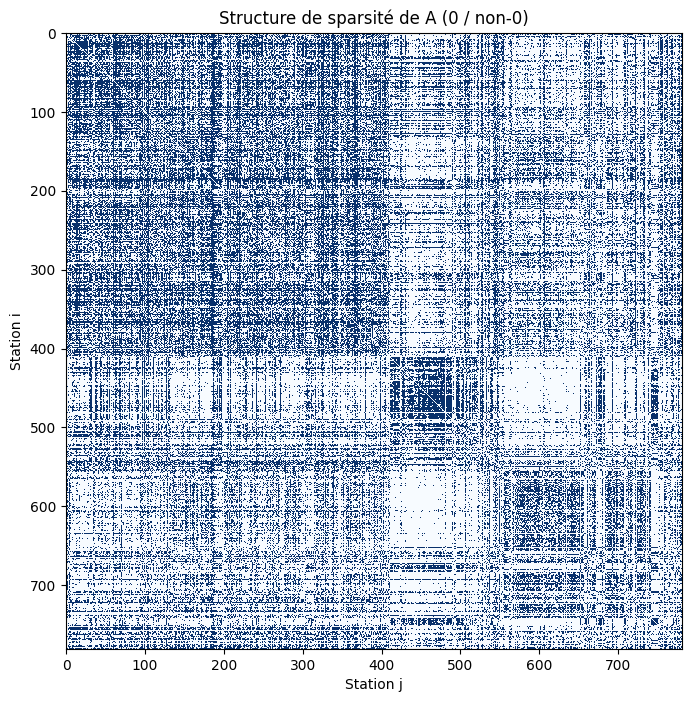

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 8))
plt.imshow((A > 0), cmap="Blues", interpolation="nearest")
plt.title("Structure de sparsité de A (0 / non‑0)")
plt.xlabel("Station j")
plt.ylabel("Station i")
plt.show()

La matrice de sparsité montre un réseau modérément connecté : la majorité des paires de stations ne présentent aucun trajet direct, mais les connexions existantes sont réparties de manière assez homogène dans l’ensemble de la matrice. L’absence de blocs denses ou de motifs réguliers suggère que le réseau ne se structure pas en communautés fortement séparées, mais plutôt en un ensemble de stations reliées de façon diffuse. On observe aussi quelques zones légèrement plus chargées, probablement liées à des stations centrales ou à des corridors de mobilité plus fréquentés. L’ensemble confirme un réseau hétérogène, sans être fragmenté, où les interactions sont nombreuses mais dispersées.

### 3) Déduction de Z à partir de A : comparaison entre approche déterministe et probabiliste

Pour déduire la matrice latente Z à partir de A, nous avons fait le choix d'un procédé comparatif entre une estimation de Z de façon déterministe grâce à la factorisation matricielle et une approche déterministe, une analyse probabiliste en composantes principales.

#### 3-1) Approche déterministe : Non-Negative Matrix Factorization

À l'aide de la factorisation NMF nous approximerons la matrice des flux $A$ par le produit de deux matrices latentes non négatives, sans modéliser explicitement le bruit présent dans les données. Cette méthode est particulièrement adaptée ici puisque notre matrice $A$ vérifie naturellement la contrainte $A[i,j]\geq 0$.
La NMF cherche une factorisation de la forme :
$A\approx ZH^{\top }$,
où :
- $Z$ contient les représentations latentes des stations,
- $H$ contient les représentations latentes des connexions entre stations.

L’objectif est de résoudre le problème d’optimisation :
$\min _{Z\geq 0,\, H\geq 0}\; \| A-ZH^{\top }\| _F^2$,
où $\| \cdot \| _F$ désigne la norme de Frobenius :
$\| M\| _F^2=\sum _{i,j}M_{ij}^2$

L’algorithme d'optimisation utilisé est celui de Lee et Seung qui repose sur des règles multiplicatives garantissant la non‑négativité des matrices tout au long de l’optimisation.

**Initialisation**
- $Z$ et $H$ sont initialisés aléatoirement, avec des valeurs non négatives.

**Mises à jour itératives**
$$H\leftarrow H\odot \frac{Z^{\top }A}{Z^{\top }ZH+\varepsilon }$$
$$Z\leftarrow Z\odot \frac{AH}{ZH^{\top }H+\varepsilon }$$
où :
- $\odot$  désigne le produit élément‑par‑élément,
- $\varepsilon$  est une petite constante pour éviter les divisions par zéro





In [16]:
from sklearn.decomposition import NMF

k = 17
model = NMF(n_components=k, init='random', random_state=42, max_iter=500, solver= 'mu')
Z_nmf = model.fit_transform(A_np) 

H = model.components_
A_reconstructed = Z_nmf @ H

# Erreur de reconstruction
error_nmf = np.mean((A_np - A_reconstructed) ** 2)

# Normalisation de Z à [0,1] par composante
Z_nmf_normalized = (Z_nmf - Z_nmf.min(axis=0)) / (Z_nmf.max(axis=0) - Z_nmf.min(axis=0) + 1e-8) # + 1e-8 pour éviter de mettre 0

print(f"  Erreur de reconstruction (MSE): {error_nmf:.4f}")
print(f"  Forme de Z: {Z_nmf_normalized.shape}")
print("Exemple de ligne (première station) :", Z_nmf_normalized[0])

# Sauvegarde pour la suite
np.save('Z_nmf.npy', Z_nmf_normalized)

  Erreur de reconstruction (MSE): 25.1204
  Forme de Z: (781, 17)
Exemple de ligne (première station) : [4.46854436e-02 8.34907706e-23 2.17061860e-14 8.61751781e-02
 1.66219709e-18 3.18798545e-17 4.09138965e-08 2.59646264e-02
 8.66401183e-31 3.48489538e-02 3.32370907e-02 1.85271798e-21
 5.99465340e-06 1.29991325e-10 5.30337224e-04 3.97051987e-11
 2.98121253e-22]


#### 3-2) Approche probabiliste

La matrice A est une matrice carrée $781\times 781$ où chaque entrée $A_{ij}$ représente un nombre entier positif : le nombre de trajets observés de la station $i$ vers la station $j$. Ces valeurs sont des comptes soumis à une forte variabilité, influencée par des facteurs aléatoires tels que la météo, les heures de pointe, les événements ponctuels ou encore les fluctuations journalières.
Pour estimer une représentation latente Z de manière probabiliste, nous faisons l’hypothèse que chaque $A_{ij}$ est la réalisation d’une variable aléatoire dont la distribution dépend de paramètres latents. Autrement dit, au lieu de considérer $A$ comme une matrice fixe, nous supposons que :
$$A_{ij}\sim p(A_{ij}\mid Z)$$

Cette approche va nous permettre de modéliser explicitement le bruit naturel présent dans les flux, d’obtenir une estimation de $Z$ plus robuste et de disposer d’une vraisemblance utile pour le clustering probabiliste (GMM) dans l’espace latent.

Notre méthode pour estimer $Z$ de manière probabiliste consiste à appliquer une ACP probabiliste (PPCA) sur la matrice $A$. Pour des données de comptage, les distributions les plus appropriées sont la Poisson et la Negative Binomial.

**Modèle Poisson** : $A_{ij}\mid Z \sim \mathrm{Poisson}(\lambda _{ij})$, avec $\lambda _{ij}>0$. La loi de Poisson impose : $\mathbb{E}[A_{ij}]=\mathrm{Var}(A_{ij})=\lambda _{ij}$

**Modèle Negative Binomial** : $A_{ij}\mid Z \sim \mathrm{NB}(\mu _{ij},\theta)$, avec $\mu _{ij}>0$. La Negative Binomial introduit un paramètre de dispersion $\theta$ , permettant de modéliser la surdispersion : $\mathrm{Var}(A_{ij})=\mu _{ij}+\frac{\mu _{ij}^2}{\theta }$

- Si $\theta$ est grand : la variance se rapproche de la moyenne (on revient à la loi Poisson).
- Si $\theta$ est petit : la variance devient beaucoup plus grande que la moyenne.

Le choix entre Poisson et Negative Binomial dépend donc directement des statistiques empiriques des flux $A_{ij}$. Dans la matrice $A$, la variance des nombre de trajets entre stations est largement supérieure à la moyenne. Nous sommes donc en situation de surdispersion, ce qui rend la Negative Binomial plus réaliste que la Poisson et bien plus adaptée qu’un modèle gaussien.

D'un autre côté, il faut souligner que dans notre jeu de données, il est légitime que certaines stations, en raison de leurs situations géographiques ou de tout autres motifs, ne puissent pas être connectées. Nous sommes donc dans un cas où, l'absence de trajets entre deux stations ($A_{ij}=0$) peut-être structurellement vraie. Pour prendre en compte ce fait, au lieu de supposer une distribution negative binomiale simple, nous préfererons une Zero Inflated Negative Binomial pour gérer les zéro structurels et les zéro aléatoires. 

Par ailleurs, les flux étant dirigés, une station $i$ n'aura pas la même représentation latente en tant que station de départ et station d'arrivée. Dès lors, pour que le flux dépende de cette contrainte nous séparerons explicitement les représentations latentes pour introduire cette relation de bilinéarité. Le flux entre une station $i$ et une station $j$ sera alors modélisé à travers une interaction bilinéaire de la forme $\textit{affinité}(i,j)=Z_i^{\top }W_j$ avec $Z_i$ la représente latente de $i$ en tant que station de départ et $W_j$, la représentation latente de $j$ en tant que station d'arrivée. Pour faire l'analogie avec la PCA, $W_i$ représente en quelque sorte une composante de la matrice de projection.  


Finalement, notre modèle s'écrit

$$
A_{ij} \mid Z_i, W_j \sim \mathrm{ZINB}(\mu_{ij}, \theta, \pi_{ij})
$$

avec :

$$
p(A_{ij} = 0)
= \pi_{ij} + (1 - \pi_{ij}) \cdot \mathrm{NB}(0 \mid \mu_{ij}, \theta)
$$

$$
p(A_{ij} = k > 0)
= (1 - \pi_{ij}) \cdot \mathrm{NB}(k \mid \mu_{ij}, \theta)
$$

**Variables latentes et paramètres**

- $Z_i \in \mathbb{R}^q$ : embedding latent de la station $i$ (origine)
- $W_j \in \mathbb{R}^q$ : embedding latent de la station $j$ (destination)
- $\mu_{ij} = \exp(Z_i^\top W_j)$, pour forcer $\mu_{ij} > 0$
- $\theta > 0$ : paramètre de dispersion NB
- $\pi_{ij} \in (0,1)$ : probabilité de zéro‑inflation

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


def zinb_log_likelihood(x, mu, theta, pi, eps=1e-8):
    t1 = torch.lgamma(theta + x) - torch.lgamma(theta) - torch.lgamma(x + 1)
    t2 = theta * torch.log(theta + eps) + x * torch.log(mu + eps)
    t3 = (theta + x) * torch.log(theta + mu + eps)
    log_nb = t1 + t2 - t3

    zero_nb = torch.pow(theta / (theta + mu + eps), theta)
    log_prob_zero = torch.log(pi + (1 - pi) * zero_nb + eps)
    log_prob_nonzero = torch.log(1 - pi + eps) + log_nb

    return torch.where(x < 1e-8, log_prob_zero, log_prob_nonzero)


class ZINBFactorModel(nn.Module):
    def __init__(self, n_samples, n_features, n_components):
        super().__init__()

        self.Z = nn.Parameter(torch.randn(n_samples, n_components))
        self.W = nn.Parameter(torch.randn(n_features, n_components))

        self.log_theta = nn.Parameter(torch.tensor(0.0))
        self.logit_pi = nn.Parameter(torch.zeros(n_features))

    def forward(self):
        eta = self.Z @ self.W.T
        mu = torch.exp(eta)

        theta = torch.exp(self.log_theta)
        pi = torch.sigmoid(self.logit_pi)

        return mu, theta, pi


# ========================
# Data
# ========================
A = torch.tensor(A_np, dtype=torch.float32)

model = ZINBFactorModel(
    n_samples=A.shape[0],
    n_features=A.shape[1],
    n_components=17
)

optimizer = optim.Adam(model.parameters(), lr=1e-2)

# ========================
# Priors (MAP)
# ========================
sigma_z = 1.0
sigma_w = 1.0

prior_z = torch.distributions.Normal(0.0, sigma_z)
prior_w = torch.distributions.Normal(0.0, sigma_w)

# ========================
# Training loop
# ========================
for epoch in range(2000):
    optimizer.zero_grad()

    mu, theta, pi = model()

    # Log-vraisemblance
    ll = zinb_log_likelihood(A, mu, theta, pi).sum()

    # Log-priors (Gaussian = ridge)
    log_pz = prior_z.log_prob(model.Z).sum()
    log_pw = prior_w.log_prob(model.W).sum()

    # MAP objective
    loss = -(ll + log_pz + log_pw)

    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss MAP: {loss.item():.2f}")


# ========================
# Diagnostics
# ========================
with torch.no_grad():
    theta_est = torch.exp(model.log_theta).item()
    pi_est = torch.sigmoid(model.logit_pi).mean().item()

Z_zinb = model.Z.detach().cpu().numpy()

Z_zinb_norm = (Z_zinb - Z_zinb.min(axis=0)) / (
    Z_zinb.max(axis=0) - Z_zinb.min(axis=0) + 1e-8
)

np.save("Z_zinb.npy", Z_zinb_norm)

A_reconstructed = torch.exp(model.Z @ model.W.T).detach().cpu().numpy()
mse = np.mean((A_np - A_reconstructed) ** 2)

print(f"MSE ZINB (indicatif): {mse:.4f}")
print(f"Dispersion NB estimée (theta): {theta_est:.4f}")
print(f"Taux moyen de zéros inflationnés (pi): {pi_est * 100:.2f}%")
print(f"Forme de Z: {Z_zinb_norm.shape}")
print("Exemple de ligne (première station):", Z_zinb_norm[0])


Epoch 0, Loss MAP: 3381715.75
Epoch 200, Loss MAP: 910836.19
Epoch 400, Loss MAP: 810732.12
Epoch 600, Loss MAP: 773897.12
Epoch 800, Loss MAP: 761729.19
Epoch 1000, Loss MAP: 755257.12
Epoch 1200, Loss MAP: 751157.19
Epoch 1400, Loss MAP: 748384.75
Epoch 1600, Loss MAP: 746476.81
Epoch 1800, Loss MAP: 745201.06
MSE ZINB (indicatif): 29.0014
Dispersion NB estimée (theta): 1.6625
Taux moyen de zéros inflationnés (pi): 3.92%
Forme de Z: (781, 17)
Exemple de ligne (première station): [0.48759684 0.6827123  0.8199896  0.28342012 0.44440314 0.37962106
 0.72868085 0.7069822  0.63542545 0.45042732 0.54087    0.6504699
 0.52433264 0.39824924 0.61154824 0.4472698  0.4733469 ]


Commentaire :

#### 3-3) Comparaison des deux méthodes

### 4) Modélisation probabiliste sur Z

###### Choix du K optimal : méthode du coude sur BIC

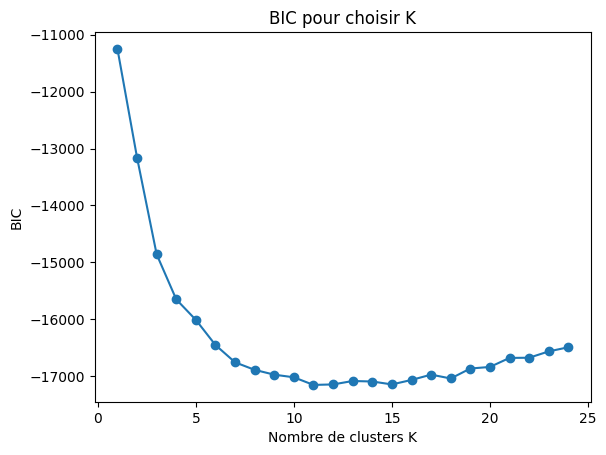

In [21]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

bics = []
ks = range(1, 25)
for k in ks:
    gmm = GaussianMixture(n_components=k, n_init=10, covariance_type = "diag", random_state=42)
    gmm.fit(Z_zinb_norm)
    bics.append(gmm.bic(Z_zinb_norm))

plt.plot(ks, bics, marker='o')
plt.title('BIC pour choisir K')
plt.xlabel('Nombre de clusters K')
plt.ylabel('BIC')
plt.show()  


Commentaire :

##### Modélisation de Z par une Gaussian Mixture avec K = 11 

In [22]:

K = 11  
gmm = GaussianMixture(n_components=K, random_state=42)
gmm.fit(Z_zinb_norm)

# Log-vraisemblance (total)
log_lik = gmm.score(Z_zinb_norm) * Z_zinb_norm.shape[0]
print(f"Log-vraisemblance : {log_lik:.2f}")

# Inférence
clusters = gmm.predict(Z_zinb_norm)

# Probs soft
probs = gmm.predict_proba(Z_zinb_norm)
print("Exemple de probs pour première station :", probs[0])

# Params estimés
print("Poids π :", gmm.weights_)
print("Moyennes μ (forme) :", gmm.means_.shape) 

Log-vraisemblance : 13655.24
Exemple de probs pour première station : [0.0000000e+00 9.9974442e-01 1.2108634e-04 0.0000000e+00 1.5287045e-05
 1.1658616e-17 0.0000000e+00 1.1901470e-04 0.0000000e+00 0.0000000e+00
 2.0262776e-42]
Poids π : [0.06274401 0.11945243 0.15629084 0.09735248 0.11508454 0.08523455
 0.04991382 0.05506517 0.11764539 0.05487495 0.08634182]
Moyennes μ (forme) : (11, 17)


Commentaire :

##### Visualisation en 2D avec TSNE

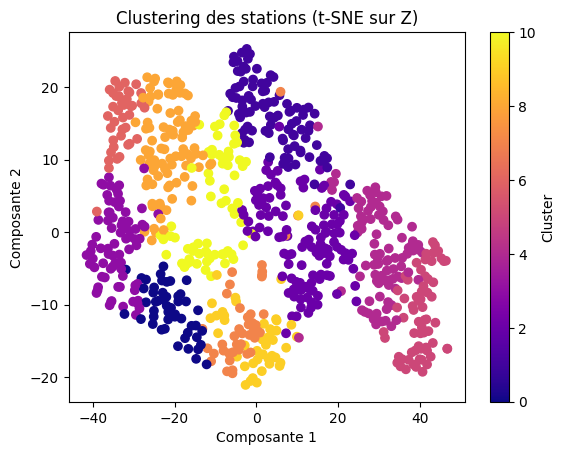

In [23]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
Z_2d = tsne.fit_transform(Z_zinb_norm)

plt.scatter(Z_2d[:,0], Z_2d[:,1], c=clusters, cmap='plasma')
plt.title('Clustering des stations (t-SNE sur Z)')
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.colorbar(label='Cluster')
plt.show()

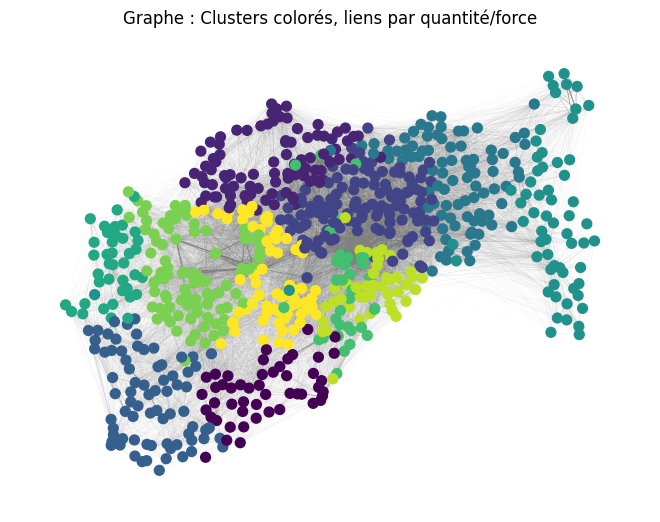

In [24]:
import networkx as nx
import pandas as pd

# Positions geo (NaN pour les 8 extra)
pos = {}
for i, sid in enumerate(all_station_ids):
    station_data = stations[stations['Station ID'] == sid]
    if not station_data.empty:
        pos[sid] = (station_data['Longitude'].values[0], station_data['Latitude'].values[0])

G = nx.Graph()
for i, sid in enumerate(all_station_ids):
    if sid in pos:
        G.add_node(sid, pos=pos[sid], cluster=clusters[i])

threshold = 5 
for i in range(n_stations):
    for j in range(i+1, n_stations):
        weight = A_np[i,j]
        # On ajoute l'arête seulement si les deux nœuds ont une position
        if weight > threshold and all_station_ids[i] in pos and all_station_ids[j] in pos:
            G.add_edge(all_station_ids[i], all_station_ids[j], weight=weight)

# Filtre pos pour ne garder que les nœuds du graphe
pos_filtered = {n: pos[n] for n in G.nodes() if n in pos}

# Dessin (geo ou spring si NaN)
# Calcul du max_weight si le graphe a des arêtes
if len(G.edges()) > 0:
    max_weight = max([d['weight'] for u, v, d in G.edges(data=True)])
    edge_widths = [d['weight']/max_weight for u, v, d in G.edges(data=True)]
else:
    edge_widths = 0.1

nx.draw(G, pos_filtered, node_color=[G.nodes[n]['cluster'] for n in G.nodes if 'cluster' in G.nodes[n]], cmap='viridis', node_size=50, edge_color='gray', width=edge_widths)
plt.title('Graphe : Clusters colorés, liens par quantité/force')
plt.show()

##### Visualisation du clustering sur la carte géographique

Carte sauvegardée comme 'stations_clusters_map.html' – Ouvrez dans navigateur pour voir.


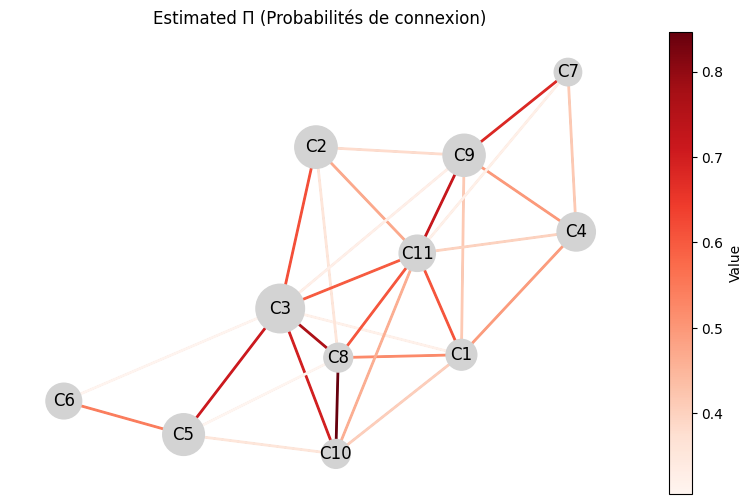

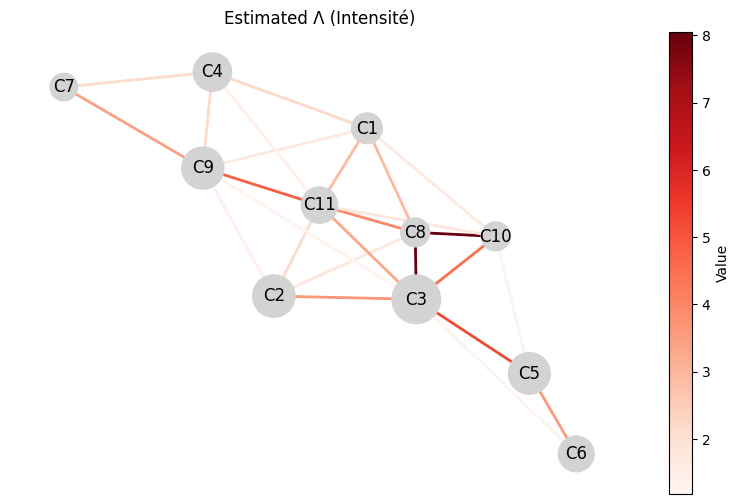

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import folium 
from folium.plugins import MarkerCluster


all_station_ids = sorted(set(stations['Station ID']) | set(journeys_clean['Start Station ID'].unique()) | set(journeys_clean['End Station ID'].unique()))

k = 11
clusters = gmm.predict(Z_zinb_norm)  # Cluster le plus probable (hard assignment)
probs = gmm.predict_proba(Z_zinb_norm)  # Probabilités soft pour chaque cluster

# Couleurs rainbow pour 11 clusters 
colors = plt.cm.hsv(np.linspace(0, 1, k))
# Convertir en hex pour folium et graphes
color_hex_list = ['#%02x%02x%02x' % (int(c[0]*255), int(c[1]*255), int(c[2]*255)) for c in colors]

# Ici, on associer les clusters et les probabilités aux stations
station_cluster = pd.DataFrame({'Station ID': all_station_ids, 'cluster': clusters})
# Ajout des probabilités pour chaque cluster
for i in range(k):
    station_cluster[f'prob_cluster_{i}'] = probs[:, i]
stations = stations.merge(station_cluster, on='Station ID', how='left')

# Plot 1: Carte géographique des stations avec clusters colorés selon probabilités (soft clustering)
# folium pour map interactive de Londres avec pie charts
import base64
from io import BytesIO
import os

map_center = [51.5074, -0.1278]  # Centre Londres
m = folium.Map(location=map_center, zoom_start=12, tiles='OpenStreetMap')

# Création d'un dossier temporaire pour les pie charts
pie_dir = 'pie_charts_temp'
os.makedirs(pie_dir, exist_ok=True)

for idx, row in stations.iterrows():
    if pd.notna(row['Latitude']) and pd.notna(row['Longitude']) and pd.notna(row['cluster']):
        # Récupération des probabilités pour tous les clusters
        probs_list = [float(row[f'prob_cluster_{i}']) for i in range(k)]
        
        # Tri des probabilités et Top N clusters (au lieu d'un seuil fixe) pour afficher plus de couleurs
        all_probs = [(i, p) for i, p in enumerate(probs_list) if p > 0]  # On filtre les prob = 0
        all_probs.sort(key=lambda x: x[1], reverse=True)
        # On garde les top 3-5 clusters pour garantir plusieurs couleurs dans les pie charts
        if len(all_probs) >= 3:
            # priorité aux plus probables
            n_top = min(5, len(all_probs))
            significant_probs = all_probs[:n_top]
        else:
            # Si moins de 3 clusters, on prend tous ceux disponibles
            significant_probs = all_probs
        
        if len(significant_probs) > 0:
            # Création d'un pie chart avec fond transparent
            fig = plt.figure(figsize=(1, 1), facecolor='none', dpi=150)
            ax = fig.add_axes([0, 0, 1, 1], facecolor='none')
            ax.set_xlim(-1.1, 1.1)
            ax.set_ylim(-1.1, 1.1)
            ax.axis('off')
            ax.set_aspect('equal')
            
            # Données pour le pie chart
            sizes = [p for _, p in significant_probs]
            labels_idx = [i for i, _ in significant_probs]
            pie_colors = [color_hex_list[i] for i in labels_idx]
            
            #  On crée des pie chart avec un contour fin pour séparer les segments
            wedges, texts = ax.pie(sizes, colors=pie_colors, startangle=90, 
                                   counterclock=False, normalize=True,
                                   wedgeprops=dict(width=1, edgecolor='white', linewidth=0.3))
            
            # Sauvegarde en mémoire
            buf = BytesIO()
            fig.patch.set_facecolor('none')
            fig.patch.set_alpha(0)
            plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0, 
                       facecolor='none', transparent=True, dpi=150, edgecolor='none')
            buf.seek(0)
            img_data = base64.b64encode(buf.read()).decode('utf-8')
            plt.close(fig)
            
            # Icône personnalisée avec fond transparent
            icon_html = f'<img src="data:image/png;base64,{img_data}" width="16" height="16" style="display: block;">'
            icon = folium.DivIcon(html=icon_html, icon_size=(16, 16), icon_anchor=(8, 8), class_name='pie-chart-icon')
            
            # Popup avec informations sur les probabilités
            top_clusters = sorted([(i, probs_list[i]) for i in range(k)], 
                                 key=lambda x: x[1], reverse=True)[:3]
            popup_text = f"Station {row['Station ID']}<br>Cluster principal: {int(row['cluster'])}<br>Top 3: " + \
                        ", ".join([f"C{i+1}({p:.2f})" for i, p in top_clusters])
            
            # Marqueur avec l'icône pie chart
            folium.Marker(
                location=[row['Latitude'], row['Longitude']],
                icon=icon,
                popup=folium.Popup(popup_text, max_width=200)
            ).add_to(m)

# Sauvegarde
m.save('stations_clusters_map.html')
print("Carte sauvegardée comme 'stations_clusters_map.html' – Ouvrez dans navigateur pour voir.")

# Plot 2: Graphes pour Π (probas connexions) et Λ (intensités) entre clusters 
# On agrége A par clusters : Π = proba lien (fraction liens >0), Λ = moyenne intensité (trajets)
cluster_pairs = np.zeros((k, k))
intensity_pairs = np.zeros((k, k))
count_pairs = np.zeros((k, k))

for i in range(len(all_station_ids)):
    for j in range(i+1, len(all_station_ids)):
        c_i = clusters[i]
        c_j = clusters[j]
        weight = A_np[i, j]
        cluster_pairs[c_i, c_j] += (weight > 0)  # Pour proba
        intensity_pairs[c_i, c_j] += weight
        count_pairs[c_i, c_j] += 1
        # Symétrisation
        cluster_pairs[c_j, c_i] = cluster_pairs[c_i, c_j]
        intensity_pairs[c_j, c_i] = intensity_pairs[c_i, c_j]
        count_pairs[c_j, c_i] = count_pairs[c_i, c_j]

# Normalisation
pi_matrix = cluster_pairs / np.maximum(count_pairs, 1)  # Proba lien
lambda_matrix = intensity_pairs / np.maximum(count_pairs, 1)  # Moyenne intensité

# Taille nœuds : Taille clusters
cluster_sizes = np.bincount(clusters, minlength=k)

# Fonction pour dessiner graphe (commun pour Π et Λ)
def draw_cluster_graph(matrix, title, cmap, threshold=0.3, scale_factor=100):
    G = nx.Graph()
    for c in range(k):
        G.add_node(c, size=cluster_sizes[c] * scale_factor, label=f"C{c+1}")

    for c_i in range(k):
        for c_j in range(c_i+1, k):
            value = matrix[c_i, c_j]
            if value > threshold:
                G.add_edge(c_i, c_j, weight=value)

    pos = nx.spring_layout(G)
    node_sizes = [G.nodes[n]['size'] for n in G.nodes]
    node_labels = {n: G.nodes[n]['label'] for n in G.nodes}
    edge_weights = [d['weight'] for u,v,d in G.edges(data=True)]
    edge_colors = edge_weights  # Pour colormap

    fig, ax = plt.subplots(figsize=(10, 6))
    nx.draw(G, pos, ax=ax, node_size=node_sizes, node_color='lightgray', with_labels=False)
    nx.draw_networkx_labels(G, pos, ax=ax, labels=node_labels)
    if len(edge_weights) > 0:
        nx.draw_networkx_edges(G, pos, ax=ax, width=2, edge_color=edge_colors, edge_cmap=cmap)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
        sm.set_array([])  # Nécessaire pour ScalarMappable
        plt.colorbar(sm, ax=ax, label='Value')
    else:
        # Pas d'arêtes, pas de colorbar
        pass
    ax.set_title(title)
    plt.show()

# Π (probas, threshold 0.3)
draw_cluster_graph(pi_matrix, 'Estimated Π (Probabilités de connexion)', plt.cm.Reds, threshold=0.3, scale_factor=10)

# Λ (intensités, threshold 1)
draw_cluster_graph(lambda_matrix, 'Estimated Λ (Intensité)', plt.cm.Reds, threshold=1, scale_factor=10)

### 5) Discussion

Pour une estimation probabiliste rigoureuse de la matrice latente Z, l’ACP probabiliste (PPCA) n’est pas le modèle le plus adapté. En effet, le PPCA repose sur des hypothèses incompatibles avec la nature des données de mobilité. Il suppose un bruit additif gaussien, une variance constante (isotropie), des données réelles continues et des valeurs non bornées. Or, les flux $A_{ij}$ sont des comptes entiers positifs, dont la variabilité est multiplicative plutôt qu’additive et discrète. Ces propriétés rendent les modèles gaussiens inadaptés pour capturer la structure statistique réelle des flux.

Pour des données de comptage, les distributions les plus appropriées sont la Poisson et la Negative Binomial.

**Modèle Poisson**
$$A_{ij}\sim \mathrm{Poisson}(\lambda _{ij}),\qquad \lambda _{ij}=\exp (Z_i\cdot Z_j)$$

Ici, le taux attendu $\lambda _{ij}$ dépend du produit scalaire entre les vecteurs latents des stations i et j, ce qui garantit $\lambda _{ij}>0$.

La loi de Poisson impose :
$\mathbb{E}[A_{ij}]=\mathrm{Var}(A_{ij})=\lambda _{ij}$


**Modèle Negative Binomial**
$$A_{ij}\sim \mathrm{NegativeBinomial}(\mu _{ij},\theta ),\qquad \mu _{ij}=\exp (Z_i\cdot Z_j)$$

La Negative Binomial introduit un paramètre de dispersion $\theta$ , permettant de modéliser la surdispersion :
$\mathrm{Var}(A_{ij})=\mu _{ij}+\frac{\mu _{ij}^2}{\theta }$

- Si $\theta$ est grand : la variance se rapproche de la moyenne (on revient à la loi Poisson).
- Si $\theta$  est petit : la variance devient beaucoup plus grande que la moyenne.

Le choix entre Poisson et Negative Binomial dépend donc directement des statistiques empiriques des flux A_{ij}. Dans notre, la variance des nombre de trajets entre stations est très largement supérieure à la moyenne. Nous sommes donc en situation de surdispersion, ce qui rend la Negative Binomial plus réaliste que la Poisson et bien plus adaptée qu’un modèle gaussien comme le PPCA.

Par conséquent, pour estimer $Z$, l’utilisation d’un modèle probabiliste non linéaire basé sur un autoencodeur variationnel sur graphe (VGAE) avec vraisemblance Negative Binomial peut être une option très pertinente.

## Suite : utiliser la matrice A du prof et le Z estimé via un modèle probabiliste non linéaire et refaire le travail pour comparaison.